In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys

GITHUB_REPO = "https://github.com/danokundaye/kidney-tumour-detection.git"
REPO_NAME = "kidney-tumour-detection"
CLONE_PATH = f"/content/{REPO_NAME}"

if os.path.exists(CLONE_PATH):
    print("Repository already exists, pulling latest changes...")
    os.chdir(CLONE_PATH)
    os.system("git pull origin main")
    print("Repository updated")
else:
    print("Cloning repository...")
    os.system(f"git clone {GITHUB_REPO} {CLONE_PATH}")
    print("Repository cloned")

if CLONE_PATH not in sys.path:
    sys.path.insert(0, CLONE_PATH)
    print(f"Added {CLONE_PATH} to Python path")

print(f"\nWorking directory: {CLONE_PATH}")
print("GitHub sync complete")

Mounted at /content/drive
Cloning repository...
Repository cloned
Added /content/kidney-tumour-detection to Python path

Working directory: /content/kidney-tumour-detection
GitHub sync complete


In [2]:
base = "/content/drive/MyDrive/kidney-tumour-detection/dataset/processed/slices/detection_train/case_00000"

print("Contents of case_00000:")
for item in os.listdir(base):
    print(f"  {item}/")
    sub = os.path.join(base, item)
    if os.path.isdir(sub):
        files = os.listdir(sub)[:3]
        for f in files:
            print(f"    {f}")

Contents of case_00000:
  images/
    slice_0000.png
    slice_0001.png
    slice_0002.png
  masks/
    slice_0000.png
    slice_0001.png
    slice_0002.png
  labels/
    slice_0000.txt
    slice_0001.txt
    slice_0002.txt


In [3]:
# Install YOLOv8
!pip install ultralytics -q

# Verify installation
from ultralytics import YOLO
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

print("All dependencies loaded successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
All dependencies loaded successfully


In [4]:
from ultralytics import YOLO
import ultralytics

# Check ultralytics version
print(f"Ultralytics version: {ultralytics.__version__}")

# Load yolov8s and inspect it
model = YOLO('yolov8s.pt')
print(f"\nModel type: {type(model.model)}")
print(f"Model task: {model.task}")

# This prints the full model summary including layer count
# YOLOv8s has ~11.2M parameters
model.info()

Ultralytics version: 8.4.14

Model type: <class 'ultralytics.nn.tasks.DetectionModel'>
Model task: detect
YOLOv8s summary: 129 layers, 11,166,560 parameters, 0 gradients, 28.8 GFLOPs


(129, 11166560, 0, 28.816844800000002)

In [5]:
# Set up project paths
DRIVE_BASE    = "/content/drive/MyDrive/kidney-tumour-detection"
PROCESSED_DIR = f"{DRIVE_BASE}/dataset/processed"
TRAIN_DIR     = f"{PROCESSED_DIR}/slices/detection_train"
YAML_PATH     = f"{PROCESSED_DIR}/splits/yolo_data.yaml"
RESULTS_DIR   = f"{DRIVE_BASE}/results/phase5_yolo"

os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"YAML path     : {YAML_PATH}")
print(f"Training data : {TRAIN_DIR}")
print(f"Results dir   : {RESULTS_DIR}")

YAML path     : /content/drive/MyDrive/kidney-tumour-detection/dataset/processed/splits/yolo_data.yaml
Training data : /content/drive/MyDrive/kidney-tumour-detection/dataset/processed/slices/detection_train
Results dir   : /content/drive/MyDrive/kidney-tumour-detection/results/phase5_yolo


Mask path: /content/drive/MyDrive/kidney-tumour-detection/dataset/processed/slices/detection_train/case_00000/masks/slice_0150.png
Mask exists: True
Mask shape: (611, 512)
Unique values in mask: [ 0 85]
Non-zero pixels: 5305


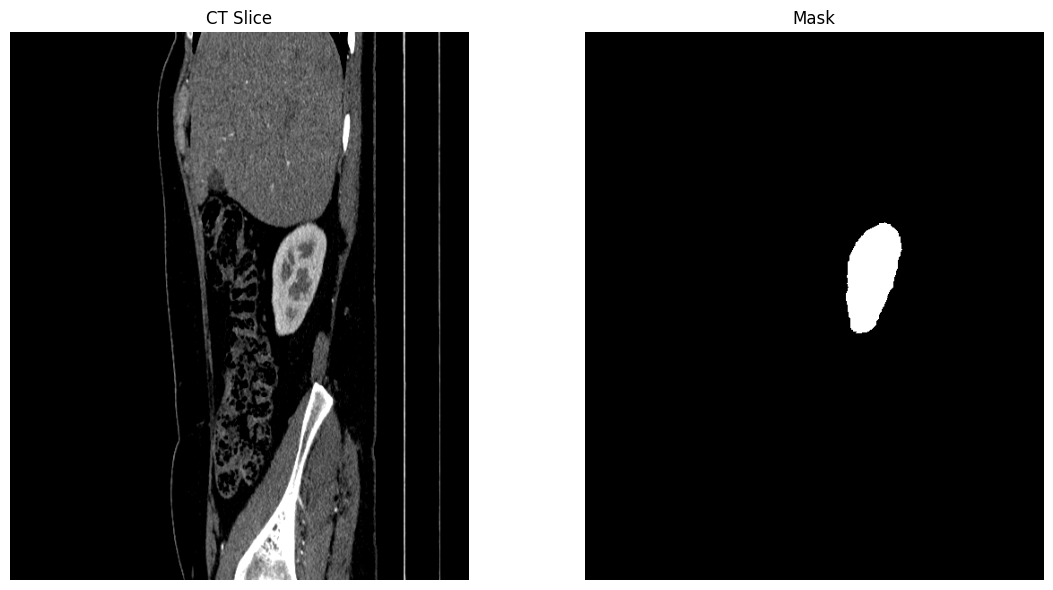

Unique values in mask: [ 0 85]
Value counts:
  value 0: 307527 pixels
  value 85: 5305 pixels


In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the mask for the same slice
mask_path = img_path.replace('/images/', '/masks/')

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

print(f"Mask path: {mask_path}")
print(f"Mask exists: {os.path.exists(mask_path)}")
print(f"Mask shape: {mask.shape}")
print(f"Unique values in mask: {np.unique(mask)}")
print(f"Non-zero pixels: {np.count_nonzero(mask)}")

# Visualise the mask alongside the image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img, cmap='gray')
axes[0].set_title("CT Slice")
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Mask")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Check what pixel values exist in this mask
print(f"Unique values in mask: {np.unique(mask)}")
print(f"Value counts:")
for val in np.unique(mask):
    count = np.sum(mask == val)
    print(f"  value {val}: {count} pixels")


 YAML contents:
    nc: 1
    names: ['kidney']
    train: /content/drive/MyDrive/kidney-tumour-detection/dataset/processed/splits/yolo_train.txt
    val: /content/drive/MyDrive/kidney-tumour-detection/dataset/processed/splits/yolo_val.txt

   Train images : 51,484
    Val images   : 5,120


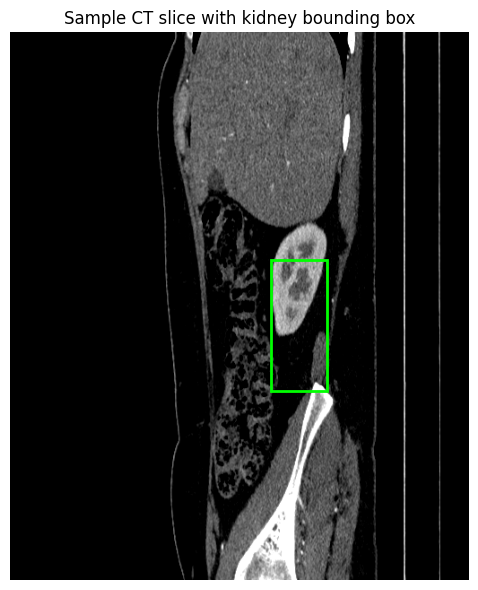


 Visualisation saved to Drive

 All sanity checks passed. Training can now commence.


In [6]:
# Verification Check
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Verify YAML
assert os.path.exists(YAML_PATH), f"YAML not found: {YAML_PATH}"

with open(YAML_PATH, 'r') as f:
    yaml_content = yaml.safe_load(f)

print("\n YAML contents:")
for key, val in yaml_content.items():
    print(f"    {key}: {val}")

# Load train/val paths and count
train_txt = yaml_content['train']
val_txt   = yaml_content['val']

assert os.path.exists(train_txt), f"Train txt not found: {train_txt}"
assert os.path.exists(val_txt),   f"Val txt not found: {val_txt}"

with open(train_txt) as f:
    train_paths = [l.strip() for l in f if l.strip()]
with open(val_txt) as f:
    val_paths = [l.strip() for l in f if l.strip()]

print(f"\n   Train images : {len(train_paths):,}")
print(f"    Val images   : {len(val_paths):,}")

# Verify a sample image and automatically find a representative slice (kidney pixels > 5000 for well-established)
sample_img_path   = None
sample_label_path = None
label_lines       = []

for img_path in train_paths:
    label_path = img_path.replace('/images/', '/labels/').replace('.png', '.txt')
    mask_path  = img_path.replace('/images/', '/masks/')

    if not os.path.exists(label_path) or not os.path.exists(mask_path):
        continue

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    kidney_px = np.sum(mask == 85)

    if kidney_px > 5000:
        with open(label_path) as f:
            lines = [l.strip() for l in f if l.strip()]
        if len(lines) > 0:
            sample_img_path   = img_path
            sample_label_path = label_path
            label_lines       = lines
            break

assert sample_img_path is not None, "No representative slice found"

# Visualise sample with bounding box
img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
assert img is not None, f"Could not read image: {sample_img_path}"
H, W = img.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap='gray')

for line in label_lines:
    parts = line.split()
    cx, cy, bw, bh = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
    x1 = (cx - bw / 2) * W    #(center_x - bbox_wdith) × image_width
    y1 = (cy - bh / 2) * H    #(center_y - bbox_height) × image_height
    rect = patches.Rectangle(
        (x1, y1),             # top-left corner in pixels
        bw * W,               # box width in pixels  (0.312 × 512 = 159.7)
        bh * H,               # box height in pixels (0.498 × 512 = 255.0)
        linewidth=2,          # thickness of the border line
        edgecolor='lime',     # green border
        facecolor='none'      # transparent inside
    )
    ax.add_patch(rect)

ax.set_title("Sample CT slice with kidney bounding box")
ax.axis('off')
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/sanity_check_sample.png", dpi=150)
plt.show()

print("\n Visualisation saved to Drive")
print("\n All sanity checks passed. Training can now commence.")

In [7]:
# Print raw label file contents and manually reconstruct
print("Raw label file contents:")
with open(label_path) as f:
    raw = f.read()
print(repr(raw))

# Manually reconstruct box from what's in the file
parts = raw.strip().split()
print(f"\nParsed parts: {parts}")

cx  = float(parts[1])
cy  = float(parts[2])
bw  = float(parts[3])
bh  = float(parts[4])

box_x1 = (cx - bw/2) * 512
box_y1 = (cy - bh/2) * 512
box_x2 = (cx + bw/2) * 512
box_y2 = (cy + bh/2) * 512

print(f"\nManual reconstruction:")
print(f"  box_y1 = ({cy} - {bh}/2) x 512 = {box_y1:.2f}")
print(f"  box_y2 = ({cy} + {bh}/2) x 512 = {box_y2:.2f}")
print(f"  box_x1 = ({cx} - {bw}/2) x 512 = {box_x1:.2f}")
print(f"  box_x2 = ({cx} + {bw}/2) x 512 = {box_x2:.2f}")

print(f"\nKidney actual: rows 200-347, cols 286-356")
print(f"Top clipping : {'YES' if box_y1 > 200 else 'NO'}")

Raw label file contents:
'0 0.628906 0.534180 0.121094 0.240234\n'

Parsed parts: ['0', '0.628906', '0.534180', '0.121094', '0.240234']

Manual reconstruction:
  box_y1 = (0.53418 - 0.240234/2) x 512 = 212.00
  box_y2 = (0.53418 + 0.240234/2) x 512 = 335.00
  box_x1 = (0.628906 - 0.121094/2) x 512 = 291.00
  box_x2 = (0.628906 + 0.121094/2) x 512 = 353.00

Kidney actual: rows 200-347, cols 286-356
Top clipping : YES


In [8]:
mask_path = "/content/drive/MyDrive/kidney-tumour-detection/dataset/processed/slices/detection_train/case_00000/masks/slice_0155.png"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Get kidney pixels
kidney_pixels = np.where(mask == 85)
if len(kidney_pixels[0]) > 0:
    row_min, row_max = kidney_pixels[0].min(), kidney_pixels[0].max()
    col_min, col_max = kidney_pixels[1].min(), kidney_pixels[1].max()
    print(f"Kidney actual bounds:")
    print(f"  rows : {row_min} to {row_max} (height = {row_max - row_min} px)")
    print(f"  cols : {col_min} to {col_max} (width  = {col_max - col_min} px)")

# Get box bounds from label
with open(label_path) as f:
    parts = f.readline().strip().split()
cx, cy, bw, bh = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
box_x1 = int((cx - bw/2) * W)
box_y1 = int((cy - bh/2) * H)
box_x2 = int((cx + bw/2) * W)
box_y2 = int((cy + bh/2) * H)

print(f"\nYOLO box bounds:")
print(f"  rows : {box_y1} to {box_y2} (height = {box_y2 - box_y1} px)")
print(f"  cols : {box_x1} to {box_x2} (width  = {box_x2 - box_x1} px)")

print(f"\nDifference:")
print(f"  top  : kidney starts at {row_min}, box starts at {box_y1} ({'OK' if box_y1 <= row_min else 'CLIPPING'})")
print(f"  bottom: kidney ends at {row_max}, box ends at {box_y2} ({'OK' if box_y2 >= row_max else 'CLIPPING'})")
print(f"  left : kidney starts at {col_min}, box starts at {box_x1} ({'OK' if box_x1 <= col_min else 'CLIPPING'})")
print(f"  right : kidney ends at {col_max}, box ends at {box_x2} ({'OK' if box_x2 >= col_max else 'CLIPPING'})")

Kidney actual bounds:
  rows : 200 to 347 (height = 147 px)
  cols : 286 to 356 (width  = 70 px)

YOLO box bounds:
  rows : 252 to 399 (height = 147 px)
  cols : 290 to 352 (width  = 62 px)

Difference:
  top  : kidney starts at 200, box starts at 252 (CLIPPING)
  bottom: kidney ends at 347, box ends at 399 (OK)
  left : kidney starts at 286, box starts at 290 (CLIPPING)
  right : kidney ends at 356, box ends at 352 (CLIPPING)


In [9]:
# Copy data to local storage
import shutil

print("Copying dataset to local Colab storage...")
print("This runs once per session — training will be much faster after\n")

LOCAL_TRAIN = "/content/yolo_data/detection_train"
os.makedirs(LOCAL_TRAIN, exist_ok=True)

# Copy entire detection_train folder from Drive to local
src = f"{TRAIN_DIR}"
dst = LOCAL_TRAIN

shutil.copytree(src, dst, dirs_exist_ok=True)

# Copy splits folder too (yaml + txt files)
shutil.copytree(
    f"{PROCESSED_DIR}/splits",
    "/content/yolo_data/splits",
    dirs_exist_ok=True
)

print("Copy complete")

# Check local read speed is better
!ls /content/yolo_data/detection_train | head -5

Copying dataset to local Colab storage...
This runs once per session — training will be much faster after

Copy complete
case_00000
case_00004
case_00005
case_00009
case_00011


In [16]:
# Update train/val txt files to point to local image paths
def update_txt_paths(src_txt, dst_txt, old_prefix, new_prefix):
    with open(src_txt) as f:
        lines = [l.strip() for l in f if l.strip()]

    updated = [l.replace(old_prefix, new_prefix) for l in lines]

    with open(dst_txt, 'w') as f:
        f.write('\n'.join(updated))

    print(f"Updated {len(updated)} paths in {os.path.basename(dst_txt)}")
    print(f"Sample: {updated[0]}")

old_prefix = TRAIN_DIR
new_prefix = "/content/yolo_data/detection_train"

update_txt_paths(
    src_txt    = f"{PROCESSED_DIR}/splits/yolo_train.txt",
    dst_txt    = "/content/yolo_data/splits/yolo_train.txt",
    old_prefix = old_prefix,
    new_prefix = new_prefix
)

update_txt_paths(
    src_txt    = f"{PROCESSED_DIR}/splits/yolo_val.txt",
    dst_txt    = "/content/yolo_data/splits/yolo_val.txt",
    old_prefix = TRAIN_DIR,
    new_prefix = "/content/yolo_data/detection_train"
)

# Verify
with open("/content/yolo_data/splits/yolo_val.txt") as f:
    lines = [l.strip() for l in f if l.strip()]

print(f"Total val paths: {len(lines)}")
print(f"First path: {lines[0]}")

# Point to local YAML from now on
YAML_PATH = "/content/yolo_data/splits/yolo_data.yaml"
print(f"YAML_PATH updated to: {YAML_PATH}")

Updated 51484 paths in yolo_train.txt
Sample: /content/yolo_data/detection_train/case_00000/images/slice_0000.png
Updated 5120 paths in yolo_val.txt
Sample: /content/yolo_data/detection_train/case_00034/images/slice_0000.png
Total val paths: 5120
First path: /content/yolo_data/detection_train/case_00034/images/slice_0000.png
YAML_PATH updated to: /content/yolo_data/splits/yolo_data.yaml


In [33]:
# Persistent plateau during model training discovered - likely due to the vast amount of background slices lacking kidney images
import os
import random

random.seed(42)

train_txt    = "/content/yolo_data/splits/yolo_train.txt"
filtered_txt = "/content/yolo_data/splits/yolo_train_filtered.txt"

with open(train_txt) as f:
    all_paths = [l.strip() for l in f if l.strip()]

kidney_large      = []  # large kidney slices → keep all
kidney_small      = []  # tiny boundary slices → discard
background_slices = []  # no kidney → keep 20%

for img_path in all_paths:
    label_path = img_path.replace('/images/', '/labels/').replace('.png', '.txt')
    if os.path.exists(label_path):
        with open(label_path) as f:
            lines = [l.strip() for l in f if l.strip()]
        if len(lines) > 0:
            # Check box size
            parts = lines[0].split()
            bw = float(parts[3])
            bh = float(parts[4])
            if bh > 0.10 and bw > 0.05:  # meaningful kidney size (25×61 pixels)
                kidney_large.append(img_path)
            else:
                kidney_small.append(img_path)
        else:
            background_slices.append(img_path)
    else:
        background_slices.append(img_path)

# Keep all large kidney slices, 20% of backgrounds, discard tiny boundary slices
kept_backgrounds = random.sample(background_slices, len(kidney_large))

filtered_paths = kidney_large + kept_backgrounds
random.shuffle(filtered_paths)

with open(filtered_txt, 'w') as f:
    f.write('\n'.join(filtered_paths))

print(f"Original         : {len(all_paths):,} images")
print(f"Large kidney     : {len(kidney_large):,} slices (kept)")
print(f"Small kidney     : {len(kidney_small):,} slices (discarded)")
print(f"Background       : {len(background_slices):,} slices")
print(f"Kept background  : {len(kept_backgrounds):,} (11.8%)")
print(f"Filtered total   : {len(filtered_paths):,} images")

Original         : 51,484 images
Large kidney     : 3,853 slices (kept)
Small kidney     : 14,942 slices (discarded)
Background       : 32,689 slices
Kept background  : 3,853 (11.8%)
Filtered total   : 7,706 images


In [34]:
LOCAL_YAML = "/content/yolo_data/splits/yolo_data.yaml"

updated_yaml = {
    'nc'   : 1,
    'names': ['kidney'],
    'train': "/content/yolo_data/splits/yolo_train_filtered.txt",
    'val'  : "/content/yolo_data/splits/yolo_val.txt"
}

with open(LOCAL_YAML, 'w') as f:
    yaml.dump(updated_yaml, f)

print("YAML updated")
with open(LOCAL_YAML) as f:
    print(f.read())

YAML updated
names:
- kidney
nc: 1
train: /content/yolo_data/splits/yolo_train_filtered.txt
val: /content/yolo_data/splits/yolo_val.txt



In [14]:
with open("/content/yolo_data/splits/yolo_val.txt") as f:
    lines = [l.strip() for l in f if l.strip()]

print(f"Total val paths: {len(lines)}")
print(f"First path: {lines[0]}")
print(f"Last path:  {lines[-1]}")

Total val paths: 5120
First path: /content/drive/MyDrive/kidney-tumour-detection/dataset/processed/slices/detection_train/case_00034/images/slice_0000.png
Last path:  /content/drive/MyDrive/kidney-tumour-detection/dataset/processed/slices/detection_train/case_00289/images/slice_0511.png


In [23]:
from ultralytics import YOLO

print("Starting YOLOv8s training (local data)...")
print("Expected time: 2-4 hours on A100\n")

model = YOLO('yolov8s.pt')

results = model.train(
    data      = YAML_PATH,
    epochs    = 100,
    imgsz     = 512,
    batch     = 16,
    optimizer = 'Adam',
    lr0       = 0.001,
    patience  = 50,
    device    = 0,
    project   = RESULTS_DIR,
    name      = 'yolov8s_run5',
    exist_ok  = True,
    save      = True,
    plots     = True,
    verbose   = True
)

print("\nTraining complete")
print(f"Results saved to: {RESULTS_DIR}/yolov8s_run5/")

Starting YOLOv8s training (local data)...
Expected time: 2-4 hours on A100

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-40GB, 40441MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_data/splits/yolo_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8s_run5, nbs

Test image: /content/yolo_data/detection_train/case_00034/images/slice_0109.png


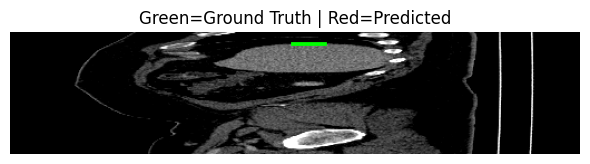

Ground truth boxes: 1
Predicted boxes   : 0


In [17]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load best model from run5
best_model = YOLO(f"{RESULTS_DIR}/yolov8s_run5/weights/best.pt")

# Find a slice with kidney from validation set
val_txt = "/content/yolo_data/splits/yolo_val.txt"
with open(val_txt) as f:
    val_paths = [l.strip() for l in f if l.strip()]

# Find first val slice with a kidney label
test_img_path = None
for path in val_paths:
    label_path = path.replace('/images/', '/labels/').replace('.png', '.txt')
    if os.path.exists(label_path):
        with open(label_path) as f:
            lines = [l.strip() for l in f if l.strip()]
        if len(lines) > 0:
            test_img_path = path
            test_label_path = label_path
            test_label_lines = lines
            break

print(f"Test image: {test_img_path}")

# Run prediction
results = best_model.predict(test_img_path, conf=0.25, verbose=False)

# Load image
img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
H, W = img.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap='gray')

# Draw ground truth in green
for line in test_label_lines:
    parts = line.split()
    cx, cy, bw, bh = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
    x1 = (cx - bw/2) * W
    y1 = (cy - bh/2) * H
    rect = patches.Rectangle((x1, y1), bw*W, bh*H,
                              linewidth=2, edgecolor='lime',
                              facecolor='none', label='Ground Truth')
    ax.add_patch(rect)

# Draw predictions in red
for box in results[0].boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    conf = box.conf[0].item()
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                              linewidth=2, edgecolor='red',
                              facecolor='none', label=f'Predicted ({conf:.2f})')
    ax.add_patch(rect)

ax.set_title("Green=Ground Truth | Red=Predicted")
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"Ground truth boxes: {len(test_label_lines)}")
print(f"Predicted boxes   : {len(results[0].boxes)}")

In [38]:
# Suspected issue, the small boxes from slices are interfering with detection due to the limited pixel size, causing the training model to plateau
large_box_count  = 0
small_box_count  = 0
no_box_count     = 0

for path in val_paths:
    label_path = path.replace('/images/', '/labels/').replace('.png', '.txt')
    if not os.path.exists(label_path):
        no_box_count += 1
        continue
    with open(label_path) as f:
        lines = [l.strip() for l in f if l.strip()]
    if len(lines) == 0:
        no_box_count += 1
    else:
        bh = float(lines[0].split()[4])
        bw = float(lines[0].split()[3])
        if bh > 0.15 and bw > 0.10:
            large_box_count += 1
        else:
            small_box_count += 1

print(f"Large boxes (bh>0.15, bw>0.10): {large_box_count:,}")
print(f"Small boxes                    : {small_box_count:,}")
print(f"No box (background)            : {no_box_count:,}")

Large boxes (bh>0.15, bw>0.10): 97
Small boxes                    : 1,759
No box (background)            : 3,264


Test image: /content/yolo_data/detection_train/case_00052/images/slice_0144.png
Label     : ['0 0.535156 0.457031 0.101562 0.335938']


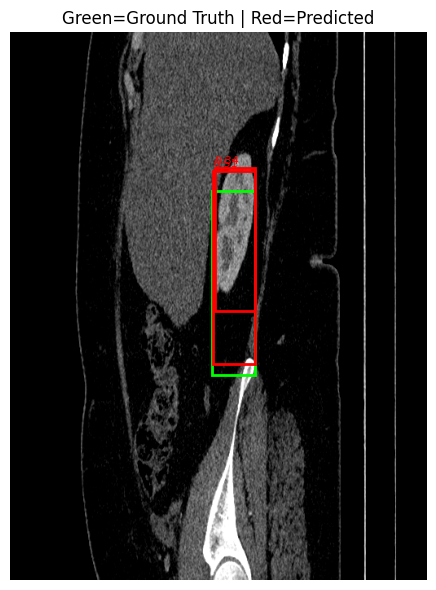

Ground truth boxes: 1
Predicted boxes   : 2


In [26]:
# Find a large box validation slice and predict
test_img_path    = None
test_label_lines = []

for path in val_paths:
    label_path = path.replace('/images/', '/labels/').replace('.png', '.txt')
    if not os.path.exists(label_path):
        continue
    with open(label_path) as f:
        lines = [l.strip() for l in f if l.strip()]
    if len(lines) > 0:
        bh = float(lines[0].split()[4])
        bw = float(lines[0].split()[3])
        if bh > 0.15 and bw > 0.10:
            test_img_path    = path
            test_label_lines = lines
            break

print(f"Test image: {test_img_path}")
print(f"Label     : {test_label_lines}")

results = best_model.predict(test_img_path, conf=0.25, verbose=False)

img  = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
H, W = img.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap='gray')

for line in test_label_lines:
    parts = line.split()
    cx, cy, bw, bh = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
    x1 = (cx - bw/2) * W
    y1 = (cy - bh/2) * H
    rect = patches.Rectangle((x1, y1), bw*W, bh*H,
                              linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)

for box in results[0].boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    conf = box.conf[0].item()
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                              linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1-5, f'{conf:.2f}', color='red', fontsize=8)

ax.set_title(f"Green=Ground Truth | Red=Predicted")
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"Ground truth boxes: {len(test_label_lines)}")
print(f"Predicted boxes   : {len(results[0].boxes)}")

In [37]:
from ultralytics import YOLO

print("Starting YOLOv8s training (local data)...")
print("Expected time: 2-4 hours on A100\n")

model = YOLO('yolov8s.pt')

results = model.train(
    data      = YAML_PATH,
    epochs    = 100,
    imgsz     = 512,
    batch     = 16,
    optimizer = 'Adam',
    lr0       = 0.001,
    patience  = 0,                # disable early stopping
    device    = 0,
    project   = RESULTS_DIR,
    name      = 'yolov8s_run8',
    exist_ok  = True,
    save      = True,
    plots     = True,
    verbose   = True
)

print("\nTraining complete")
print(f"Results saved to: {RESULTS_DIR}/yolov8s_run8/")

Starting YOLOv8s training (local data)...
Expected time: 2-4 hours on A100

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-40GB, 40441MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_data/splits/yolo_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8s_run8, nbs

In [40]:
import yaml

# Create large val txt
val_txt = "/content/yolo_data/splits/yolo_val.txt"
with open(val_txt) as f:
    val_paths = [l.strip() for l in f if l.strip()]

large_val_paths = []
for path in val_paths:
    label_path = path.replace('/images/', '/labels/').replace('.png', '.txt')
    if not os.path.exists(label_path):
        continue
    with open(label_path) as f:
        lines = [l.strip() for l in f if l.strip()]
    if len(lines) > 0:
        bw = float(lines[0].split()[3])
        bh = float(lines[0].split()[4])
        if bh > 0.10 and bw > 0.05:
            large_val_paths.append(path)

large_val_txt = "/content/yolo_data/splits/yolo_val_large.txt"
with open(large_val_txt, 'w') as f:
    f.write('\n'.join(large_val_paths))

print(f"Large val slices: {len(large_val_paths)}")

# Create yaml
large_val_yaml = "/content/yolo_data/splits/yolo_data_large_val.yaml"
with open(large_val_yaml, 'w') as f:
    yaml.dump({
        'nc'   : 1,
        'names': ['kidney'],
        'train': "/content/yolo_data/splits/yolo_train_filtered.txt",
        'val'  : large_val_txt
    }, f)

print(f"YAML created: {large_val_yaml}")

Large val slices: 246
YAML created: /content/yolo_data/splits/yolo_data_large_val.yaml


In [43]:
# Compare the best epoch to the last epoch
best_pt = f"{RESULTS_DIR}/yolov8s_run8/weights/best.pt"
last_pt = f"{RESULTS_DIR}/yolov8s_run8/weights/last.pt"

for name, path in [("best.pt (epoch 81)", best_pt),
                   ("last.pt (epoch 100)", last_pt)]:
    model   = YOLO(path)
    metrics = model.val(data=large_val_yaml, imgsz=512, verbose=False)
    print(f"\n{name}")
    print(f"  mAP@0.5   : {metrics.box.map50:.4f}")
    print(f"  Precision : {metrics.box.mp:.4f}")
    print(f"  Recall    : {metrics.box.mr:.4f}")

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-40GB, 40441MiB)
Model summary (fused): 73 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1702.8±838.4 MB/s, size: 63.0 KB)
val: Scanning /content/yolo_data/detection_train/case_00052/labels.cache... 246 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 246/246 93.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 11.2it/s 1.4s
                   all        246        250      0.475      0.476      0.375      0.157
Speed: 0.4ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/runs/detect/val5

best.pt (epoch 81)
  mAP@0.5   : 0.3746
  Precision : 0.4750
  Recall    : 0.4760
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-40GB, 40441MiB)
Model summary (fused): 73 layers, 11,125,971 parameters, 0 gradi

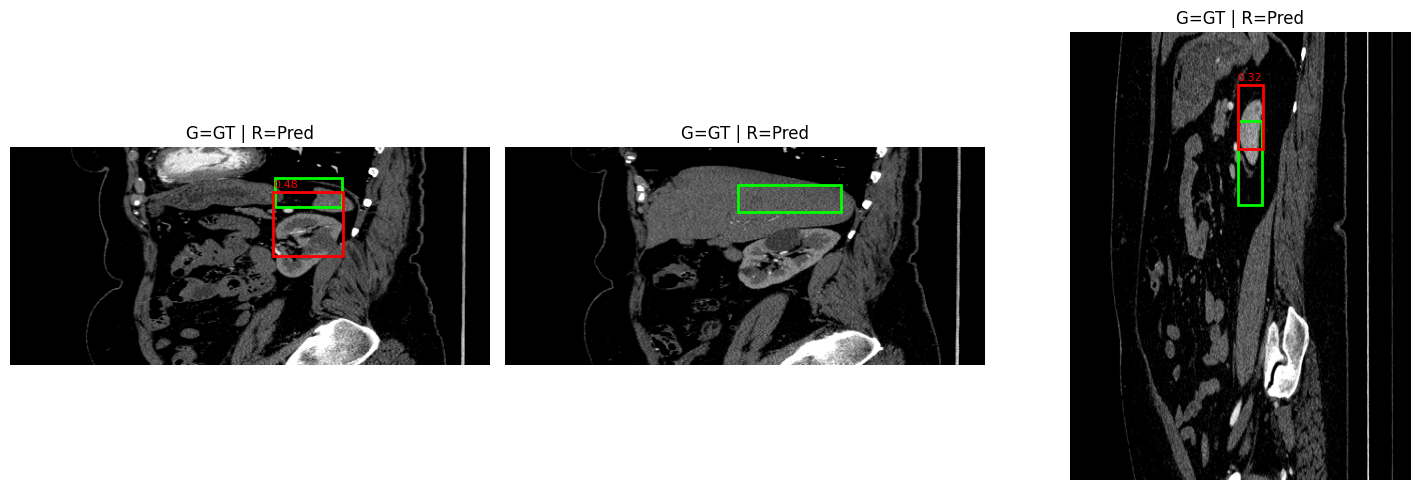

In [44]:
import random

model = YOLO(f"{RESULTS_DIR}/yolov8s_run8/weights/best.pt")

# Pick 3 random large val slices
sample_paths = random.sample(large_val_paths, 3)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, path in zip(axes, sample_paths):
    results  = model.predict(path, conf=0.25, verbose=False)
    img      = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    H, W     = img.shape
    ax.imshow(img, cmap='gray')

    label_path = path.replace('/images/', '/labels/').replace('.png', '.txt')
    with open(label_path) as f:
        lines = [l.strip() for l in f if l.strip()]
    for line in lines:
        parts = line.split()
        cx, cy, bw, bh = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
        x1 = (cx - bw/2) * W
        y1 = (cy - bh/2) * H
        rect = patches.Rectangle((x1,y1), bw*W, bh*H,
                                  linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        conf = box.conf[0].item()
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                  linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, f'{conf:.2f}', color='red', fontsize=8)

    ax.set_title(f"G=GT | R=Pred")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [49]:
# View results
model = YOLO(f"{RESULTS_DIR}/yolov8s_run8/weights/best.pt")
metrics = model.val(data=large_val_yaml, imgsz=512,
                    conf=0.10, verbose=False)
print(f"mAP@0.5  : {metrics.box.map50:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall   : {metrics.box.mr:.4f}")

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-40GB, 40441MiB)
Model summary (fused): 73 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2231.6±961.7 MB/s, size: 92.3 KB)
val: Scanning /content/yolo_data/detection_train/case_00052/labels.cache... 246 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 246/246 86.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 10.7it/s 1.5s
                   all        246        250      0.475      0.476      0.377      0.159
Speed: 0.4ms preprocess, 1.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/runs/detect/val9
mAP@0.5  : 0.3773
Precision: 0.4750
Recall   : 0.4760


In [47]:
# Check how many of the 246 large val slices the model actually detects
model = YOLO(f"{RESULTS_DIR}/yolov8s_run8/weights/best.pt")

detected = 0
missed   = 0

for path in large_val_paths:
    results = model.predict(path, conf=0.25, verbose=False)
    if len(results[0].boxes) > 0:
        detected += 1
    else:
        missed += 1

print(f"Detected: {detected} ({detected/len(large_val_paths)*100:.1f}%)")
print(f"Missed  : {missed}  ({missed/len(large_val_paths)*100:.1f}%)")

Detected: 193 (78.5%)
Missed  : 53  (21.5%)


In [50]:
# Create val file with large slices
import random
random.seed(42)

val_txt = "/content/yolo_data/splits/yolo_val.txt"
with open(val_txt) as f:
    val_paths = [l.strip() for l in f if l.strip()]

large_val  = []
bg_val     = []

for path in val_paths:
    label_path = path.replace('/images/', '/labels/').replace('.png', '.txt')
    if not os.path.exists(label_path):
        bg_val.append(path)
        continue
    with open(label_path) as f:
        lines = [l.strip() for l in f if l.strip()]
    if len(lines) == 0:
        bg_val.append(path)
    else:
        bw = float(lines[0].split()[3])
        bh = float(lines[0].split()[4])
        if bh > 0.10 and bw > 0.05:
            large_val.append(path)

kept_bg = random.sample(bg_val, len(large_val))
filtered_val = large_val + kept_bg
random.shuffle(filtered_val)

filtered_val_txt = "/content/yolo_data/splits/yolo_val_filtered.txt"
with open(filtered_val_txt, 'w') as f:
    f.write('\n'.join(filtered_val))

print(f"Large kidney : {len(large_val)}")
print(f"Background   : {len(kept_bg)}")
print(f"Total        : {len(filtered_val)}")

Large kidney : 246
Background   : 246
Total        : 492


In [52]:
# Update YAML to use filtered val set
with open(LOCAL_YAML, 'w') as f:
    yaml.dump({
        'nc'   : 1,
        'names': ['kidney'],
        'train': "/content/yolo_data/splits/yolo_train_filtered.txt",
        'val'  : "/content/yolo_data/splits/yolo_val_filtered.txt"
    }, f)

print("YAML updated")
with open(LOCAL_YAML) as f:
    print(f.read())

YAML updated
names:
- kidney
nc: 1
train: /content/yolo_data/splits/yolo_train_filtered.txt
val: /content/yolo_data/splits/yolo_val_filtered.txt



In [53]:
model = YOLO('yolov8s.pt')

results = model.train(
    data      = LOCAL_YAML,
    epochs    = 100,
    imgsz     = 512,
    batch     = 16,
    optimizer = 'Adam',
    lr0       = 0.001,
    patience  = 0,
    device    = 0,
    project   = RESULTS_DIR,
    name      = 'yolov8s_run10',
    exist_ok  = True,
    save      = True,
    plots     = True,
    verbose   = True
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-40GB, 40441MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_data/splits/yolo_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8s_run10, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=Tr

In [54]:
for name, path in [("best.pt", f"{RESULTS_DIR}/yolov8s_run10/weights/best.pt"),
                   ("last.pt", f"{RESULTS_DIR}/yolov8s_run10/weights/last.pt")]:
    model   = YOLO(path)
    metrics = model.val(data=large_val_yaml, imgsz=512, verbose=False)
    print(f"\n{name}")
    print(f"  mAP@0.5   : {metrics.box.map50:.4f}")
    print(f"  Precision : {metrics.box.mp:.4f}")
    print(f"  Recall    : {metrics.box.mr:.4f}")

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-40GB, 40441MiB)
Model summary (fused): 73 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1875.2±512.2 MB/s, size: 79.7 KB)
val: Scanning /content/yolo_data/detection_train/case_00052/labels.cache... 246 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 246/246 93.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 10.8it/s 1.5s
                   all        246        250      0.775      0.497      0.619      0.251
Speed: 0.5ms preprocess, 0.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/runs/detect/val10

best.pt
  mAP@0.5   : 0.6191
  Precision : 0.7752
  Recall    : 0.4966
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-40GB, 40441MiB)
Model summary (fused): 73 layers, 11,125,971 parameters, 0 gradients, 28.4

In [55]:
model    = YOLO(f"{RESULTS_DIR}/yolov8s_run10/weights/best.pt")
detected = 0
missed   = 0

for path in large_val_paths:
    results = model.predict(path, conf=0.25, verbose=False)
    if len(results[0].boxes) > 0:
        detected += 1
    else:
        missed += 1

print(f"Detected: {detected} ({detected/len(large_val_paths)*100:.1f}%)")
print(f"Missed  : {missed}  ({missed/len(large_val_paths)*100:.1f}%)")

Detected: 174 (70.7%)
Missed  : 72  (29.3%)


In [56]:
model    = YOLO(f"{RESULTS_DIR}/yolov8s_run10/weights/best.pt")

for conf_thresh in [0.25, 0.15, 0.10, 0.05]:
    detected = 0
    for path in large_val_paths:
        results = model.predict(path, conf=conf_thresh, verbose=False)
        if len(results[0].boxes) > 0:
            detected += 1
    print(f"conf={conf_thresh}: {detected}/246 ({detected/246*100:.1f}%)")

conf=0.25: 174/246 (70.7%)
conf=0.15: 219/246 (89.0%)
conf=0.1: 232/246 (94.3%)
conf=0.05: 245/246 (99.6%)


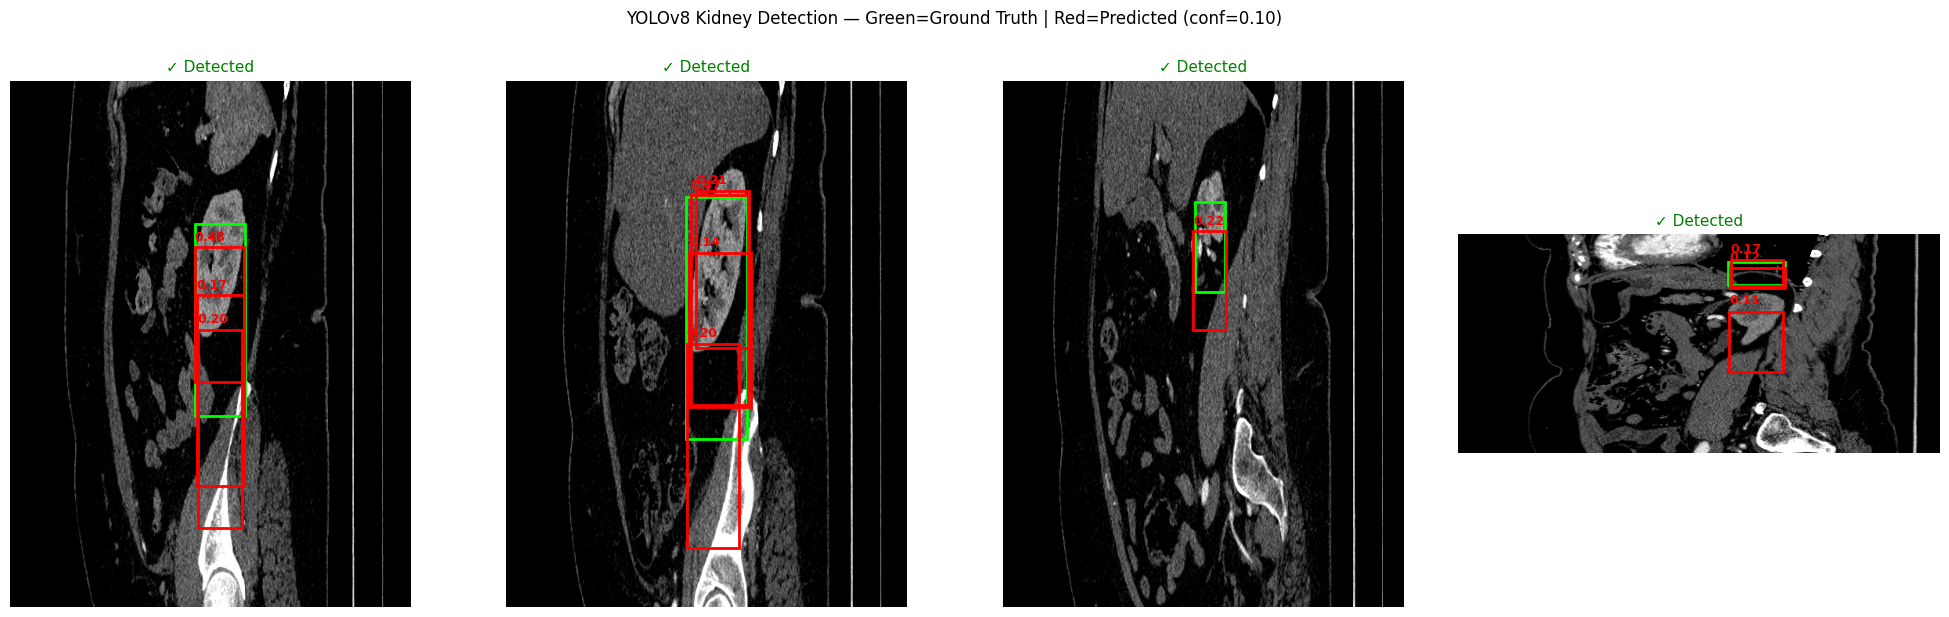

Saved to Drive


In [57]:
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

model = YOLO(f"{RESULTS_DIR}/yolov8s_run10/weights/best.pt")

# Pick 4 random large val slices
sample_paths = random.sample(large_val_paths, 4)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for ax, path in zip(axes, sample_paths):
    results = model.predict(path, conf=0.10, verbose=False)
    img     = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    H, W    = img.shape
    ax.imshow(img, cmap='gray')

    # Ground truth in green
    label_path = path.replace('/images/', '/labels/').replace('.png', '.txt')
    with open(label_path) as f:
        lines = [l.strip() for l in f if l.strip()]
    for line in lines:
        parts = line.split()
        cx, cy, bw, bh = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
        x1 = (cx - bw/2) * W
        y1 = (cy - bh/2) * H
        rect = patches.Rectangle((x1, y1), bw*W, bh*H,
                                  linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

    # Predictions in red
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        conf = box.conf[0].item()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                  linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-8, f'{conf:.2f}', color='red',
                fontsize=9, fontweight='bold')

    detected = len(results[0].boxes) > 0
    ax.set_title(f"{'✓ Detected' if detected else '✗ Missed'}",
                 color='green' if detected else 'red', fontsize=11)
    ax.axis('off')

plt.suptitle("YOLOv8 Kidney Detection — Green=Ground Truth | Red=Predicted (conf=0.10)",
             fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/kidney-tumour-detection/results/phase5_yolo/detection_examples.png",
            dpi=150, bbox_inches='tight')
plt.show()
print("Saved to Drive")